In [21]:
import os

import matplotlib.pyplot as plt
import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from dotenv import load_dotenv
from numpy import pi
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    transpile)
from qiskit.ignis.verification.tomography import (StateTomographyFitter,
                                                  state_tomography_circuits)
from qiskit.providers.aer import AerSimulator, noise
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.quantum_info import partial_trace
from qutip import Bloch, Bloch3d, Qobj

from sync_calcs import dm2bloch
from sync_gates import add_tomography

from tqdm import tqdm
from tqdm.contrib import tenumerate

load_dotenv()

import logging
logging.getLogger('qiskit.providers.ibmq').setLevel(logging.ERROR)

# IBMQ.ibmq.save_account(os.environ['TOKEN'], overwrite=True)

In [22]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open', project='main')
job_manager = IBMQJobManager()

In [23]:
# backend = provider.get_backend('ibmq_quito') # Real
backend = provider.get_backend('ibmq_athens') # Real
# backend = provider.get_backend('ibmq_santiago') # Real - ibmq_santiago seems to have the lowest CNOT noise
# backend = AerSimulator.from_backend(backend) # Noisy Sim
# backend = AerSimulator() # Ideal Sim

# noise_model = noise.NoiseModel().from_backend(backend)

is_real_device = not backend.name().startswith('aer_simulator')

max_shots = backend.configuration().to_dict()["max_shots"]
max_shots

8192

# Parameters

In [24]:
# Simulation Steps
SIM_STEPS = 8
SKIP = 1
SHOTS = 8192

# Qubits of physical device to use
# Ordered from zero
main = 1
ancilla = 2

r = 0.1

loss_amp = 1
gain_amp = loss_amp * r
m = min(loss_amp, gain_amp)

detuning = 2 * 3 * m
signal_strength = 2 * 2 * m
# dt = 2
# dt = (np.logspace(0.1, 0.7, SIM_STEPS, endpoint=True)) / 10

dt = 0.5
# dt = (np.linspace(2, 5, SIM_STEPS, endpoint=True))
# dt

# Circuit

In [25]:
def generate_circuit(time_steps, detuning, signal_strength, steps, main, ancilla):
    qreg_q = QuantumRegister(max(main, ancilla) + 1, "q")
    creg_c = ClassicalRegister(2, "c")

    qc = QuantumCircuit(qreg_q, creg_c)

    for i in range(steps):
        if hasattr(time_steps, "__iter__"):
            dt = time_steps[i]
        else:
            dt = time_steps
        theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
        theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

        theta = signal_strength * dt
        phi = pi - detuning * dt / 2
        lam = pi - detuning * dt / 2

        qc.u(theta, phi, lam, qreg_q[main])

        # Loss CU
        # qc.cu(theta_d, 0, 0, 0, qreg_q[main], qreg_q[ancilla])
        # qc.cx(qreg_q[ancilla], qreg_q[main])
        # qc.measure(qreg_q[ancilla], creg_c[0])
        # qc.reset(qreg_q[ancilla])

        # Loss 2xCX
        qc.u(pi / 2, -pi, 0, qreg_q[main])
        qc.u(-theta_d / 2, -pi / 2, pi, qreg_q[ancilla])
        qc.cx(qreg_q[ancilla], qreg_q[main])
        qc.u(pi / 2, -pi / 2, 0, qreg_q[main])
        qc.u(-theta_d / 2, pi, pi / 2, qreg_q[ancilla])
        qc.cx(qreg_q[ancilla], qreg_q[main])
        qc.u(0, 0, -pi / 2, qreg_q[main])
        qc.u(0, 0, -pi / 2, qreg_q[ancilla])
        qc.measure(qreg_q[ancilla], creg_c[0])
        qc.reset(qreg_q[ancilla])

        # # Gain
        # qc.u(-pi, 0, 0, qreg_q[main])
        # qc.cx(qreg_q[main], qreg_q[ancilla])
        # qc.cu(theta_g, 0, 0, 0, qreg_q[main], qreg_q[ancilla])
        # qc.cx(qreg_q[main], qreg_q[ancilla])
        # qc.u(pi, 0, 0, qreg_q[main])
        # qc.measure(qreg_q[ancilla], creg_c[0])
        # qc.reset(qreg_q[ancilla])

    # qc.measure(qreg_q[0], creg_c[1])

    return qc


# Tomography

In [26]:
circuits = [generate_circuit(dt, detuning, signal_strength, i, main, ancilla) for i in tqdm(range(0, SIM_STEPS + 1, SKIP))]

circuits_with_tomo = [list(add_tomography(circuit, 2, main, ancilla)) for circuit in tqdm(circuits)]

compiled_circuits_with_tomo = [transpile(circuit, backend) for circuit in tqdm(circuits_with_tomo)]

  0%|          | 0/9 [00:00<?, ?it/s]

KeyError: 'qubits'

# Calibration

In [ ]:
try:
    if measurement_calibration_circuit:
        pass
except NameError:
    measurement_calibration_circuit, state_labels = mc.complete_meas_cal(qubit_list=[main, ancilla])

    if is_real_device:
        calibration_job = job_manager.run(measurement_calibration_circuit, backend=backend, name="QSync_calibration")
        result = calibration_job.results().combine_results()
    else:
        calibration_job = backend.run(measurement_calibration_circuit, shots=SHOTS)
        result = calibration_job.result()

    measurement_calibration_fitter = mc.CompleteMeasFitter(result, state_labels)
    measurement_calibration_fitter.cal_matrix

# Simulation

In [ ]:
jobs = []
if not is_real_device:
    for i, circuit in tenumerate(compiled_circuits_with_tomo):
        # print(f"Job Submission {i} of {len(compiled_circuits_with_tomo)}")
        job = backend.run(circuit, name=f"QSync_{i}", shots=SHOTS)
        jobs.append(job)
else:
    for i, circuit in tenumerate(compiled_circuits_with_tomo):
        # print(f"Job Submission {i} of {len(compiled_circuits_with_tomo)}")
        job = job_manager.run(circuit, backend=backend, name=f"QSync_{i}", shots=SHOTS)
        jobs.append(job)


100%|██████████| 9/9 [00:02<00:00,  3.66it/s]


In [ ]:
uncorrected_states = []

for i, (job, circuit) in tenumerate(zip(jobs, compiled_circuits_with_tomo)):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    tomo_state = StateTomographyFitter(result, circuit)
    state = tomo_state.fit(method="lstsq")

    uncorrected_states.append(state)


9it [00:00, 321.13it/s]


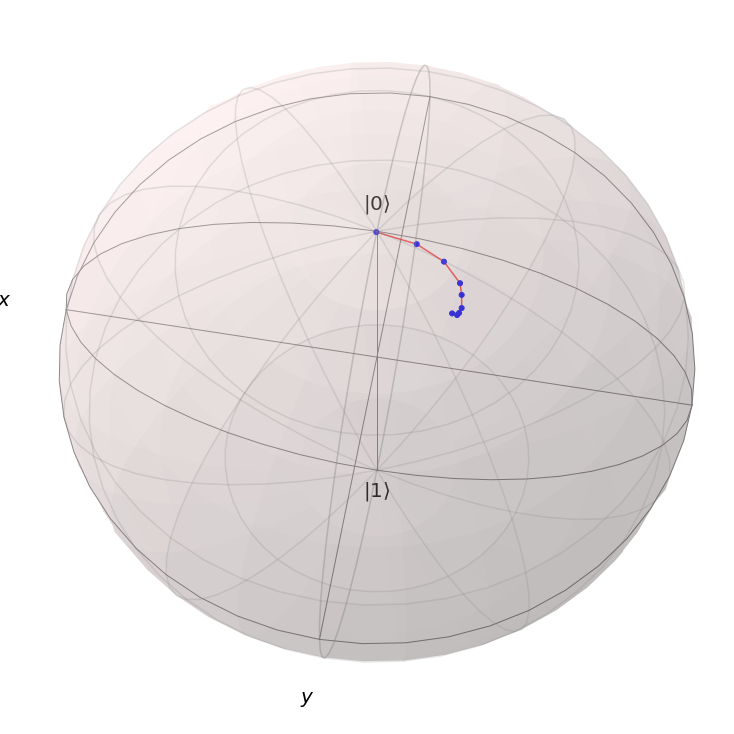

In [ ]:
b = Bloch(figsize=[10,10])
states = [partial_trace(s, [1]).data for s in uncorrected_states]
points = dm2bloch(states)
b.add_points(points, meth="s")
b.add_points(points, meth="l")

b.view = [10, 60]
b.show()

In [ ]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Jobs File Name: ")

    with open(f"{name}.txt", "w") as f:
        f.write("Calibration:\n")
        f.write(f"{calibration_job.job_set_id()}\n")
        f.write("\n")
        f.write("Simulation:\n")
        for job in jobs:
            id_ = job.job_set_id()
            f.write(f"{id_}\n")

In [ ]:
corrected_states = []

for job, circuit in tqdm(zip(jobs, compiled_circuits_with_tomo)):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    corrected_result = measurement_calibration_fitter.filter.apply(result, method="least_squares")
    mitigated_tomo_state = StateTomographyFitter(corrected_result, circuit)
    state = mitigated_tomo_state.fit(method="lstsq")

    corrected_states.append(state)

9it [00:00, 62.44it/s]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.99850306+0.j         -0.0034028 -0.00581457j]
 [-0.0034028 +0.00581457j  0.00149694+0.j        ]]

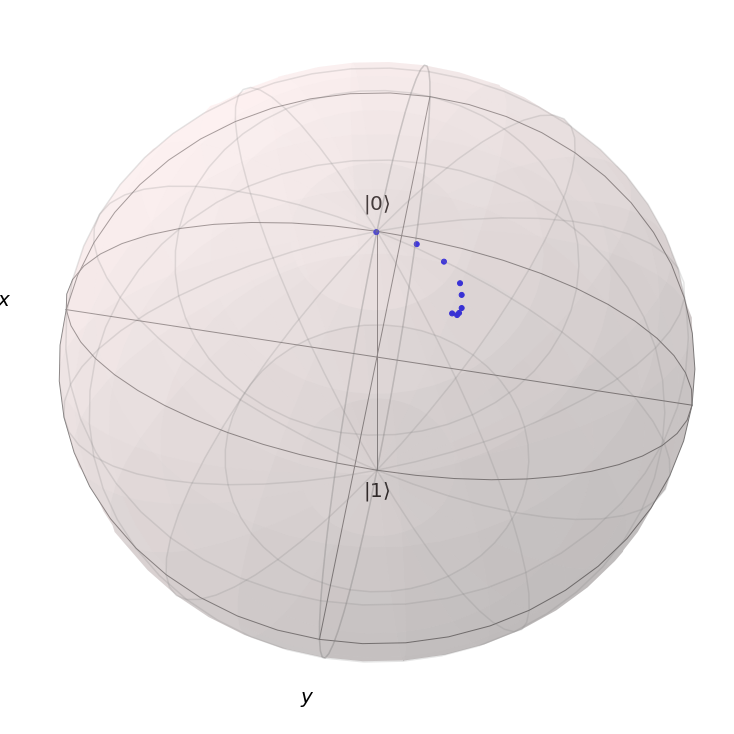

In [ ]:
b = Bloch(figsize=[10, 10])
# b = Bloch3d()
states = [partial_trace(s, [1]).data for s in corrected_states]
points = dm2bloch(states)
# b.add_points(points, meth="l")
b.add_points(points, meth="s")
# b.add_points(points, meth="s")
b.view = [10, 60]
b.show()
Qobj(corrected_states[-1], dims=[[2, 2], [2, 2]]).ptrace(0)

(<Figure size 963.78x297.824 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi\\,|\\,\\hat\\rho)$'>))

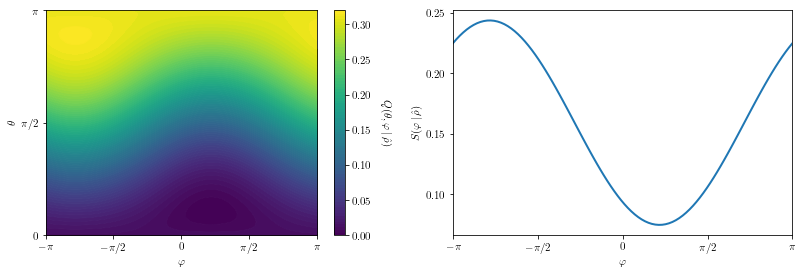

In [ ]:
from sync_plots import calc_and_plot_Q_and_S
ss = partial_trace(corrected_states[-1], [1]).data
calc_and_plot_Q_and_S(Qobj(ss), method="qutip")

In [ ]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Data File Name: ")
    np.save(f'{name}.npy', [partial_trace(s, [1]).data for s in corrected_states])

In [ ]:
# data = []

# for i in range(1, 4):
#     d = np.load(f"loss-v5-{i}.npy")
#     data.append(d)

# data = np.array(data)#[(0, 1, 2), :, :]

# mean_states = np.mean(data, axis=0)
# std_states = np.std(data, axis=0)

# ups = [state[0, 0].real for state in mean_states]
# ups_std = [state[0, 0].real for state in std_states]

# downs = [state[1, 1].real for state in mean_states]
# downs_std = [state[1, 1].real for state in std_states]

In [ ]:
# b = Bloch3d()
# points = dm2bloch(mean_states)
# b.add_points(points)
# b.add_points(points, 'l')

# b.show()

In [ ]:
# from scipy.signal import savgol_filter

# fig, ax = plt.subplots(figsize=[5, 7])

# t = np.linspace(2, 5, 12, endpoint=True)
# dis_t = [0, *np.cumsum(t)]
# ax.errorbar(dis_t, ups, fmt="+", yerr=ups_std, capsize=2, c="teal", label=r"$\hat\rho_{0,0}$")
# ax.errorbar(dis_t, downs, fmt="+", yerr=downs_std, capsize=2, c="orange", label=r"$\hat\rho_{1,1}$")

# cont_states = np.load("loss-v5-cont.npy")
# cont_ups = [state[0, 0].real for state in cont_states]
# cont_downs = [state[1, 1].real for state in cont_states]

# ct = np.arange(len(corrected_states)) * dt

# ax.plot(ct, savgol_filter(cont_ups, 51, 7))
# ax.plot(ct, savgol_filter(cont_downs, 51, 7))
